# This code demonstrates a estimation of sequence of latent states from a time-series data with Viterbi algorithm

# load required packages

In [1]:
using Revise; using MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/seica/.julia/packages/Revise/ucYAZ/src/Revise.jl:1331
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


# generate time-series data

In [2]:
# ground-truth transition probabilities
T = [
0.8 0.1 0.1;
0.2 0.5 0.3;
0.1 0.1 0.8;
]

3×3 Array{Float64,2}:
 0.8  0.1  0.1
 0.2  0.5  0.3
 0.1  0.1  0.8

In [3]:
# equilibrium probabilities
pi_i = [
0.33333, 
0.33333, 
0.33333,
]

3-element Array{Float64,1}:
 0.33333
 0.33333
 0.33333

In [4]:
# emission probabilities
emission = [
0.9 0.1;
0.5 0.5;
0.1 0.9;
]

3×2 Array{Float64,2}:
 0.9  0.1
 0.5  0.5
 0.1  0.9

In [5]:
state, observation = msmgenerate(200, T, pi_i, emission)

([1, 1, 1, 1, 1, 1, 3, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 1, 1, 1, 1], [1, 1, 2, 1, 1, 1, 1, 2, 2, 2  …  2, 2, 2, 2, 1, 2, 1, 2, 1, 1])

# Viterbi algorithm

In [30]:
function msmviterbi(observation, T, pi_i, emission, candidate = 1)
    nframe = size(observation, 1)
    nstate = size(T, 1)
    P = ones(eltype(T), nframe, nstate, candidate) * -Inf
    I = ones(Int64, nframe, nstate, candidate, 2) .* -1
    state_estimated = zeros(eltype(observation), nframe, candidate)

    # initialization
    P[1, :, 1] .= log.(pi_i) .+ log.(emission[:, observation[1]])

    # argmax forward
    Z = zeros(eltype(T), nstate, nstate)
    for t = 1:(nframe-1)
        for s_from = 1:nstate
            for c_from = 1:candidate
                for s_to = 1:nstate
                    tmp_p = P[t, s_from, c_from] + log(T[s_from, s_to]) + log(emission[s_to, observation[t+1]])
                    tmp_i = [s_from, c_from]
                    for c_to = 1:candidate
                        if P[t+1, s_to, c_to] < tmp_p
                            P[t+1, s_to, c_to], tmp_p = tmp_p,  P[t+1, s_to, c_to]
                            I[t+1, s_to, c_to, :], tmp_i = tmp_i,  I[t+1, s_to, c_to, :]
                        end
                    end
                end
            end
        end
    end
    
    for e = 1:candidate
        i = argmax(P[nframe, :, :])
        state_estimated[nframe, e] = i[1]
        P[nframe, i[1], i[2]] = -Inf
        for t = (nframe-1):-1:1
            i = I[t+1, i[1], i[2], :]
            state_estimated[t, e] = i[1]
        end
    end

    return state_estimated
end

msmviterbi (generic function with 2 methods)

In [31]:
@time state_estimated = msmviterbi(observation, T, pi_i, emission, 2);

  0.220576 seconds (608.91 k allocations: 28.664 MiB)


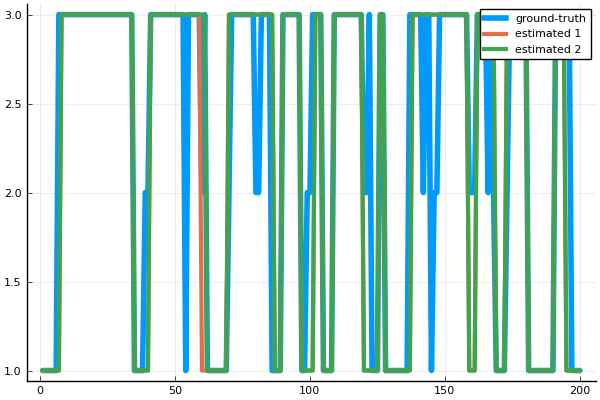

In [32]:
using Plots
pyplot()
plot(state, line=(4), label="ground-truth")
plot!(state_estimated[:, 1], line=(3), label="estimated 1", legend=:topright)
plot!(state_estimated[:, 2], line=(3), label="estimated 2", legend=:topright)